In [2]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhouya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
#import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

D:\python\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [4]:
import spacy

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
from time import time
print("Loading dataset...")
t0 = time()
data=[]

f=open("savedrecs.txt","r",encoding='utf-8')
stopwords = [word.strip() for word in open('stopwords.txt','r').readlines()]
f.readline()
for line in f:
    #print (line.startswith('AB'))K1TI
    if line.startswith('TI') == True :
        if len(line.lstrip('TI').strip())>0:
            data.append(line.lstrip('TI').strip()) 

print("done in %0.3fs." % (time() - t0))

data_ = [[word for word in doc.lower().split() if word not in stopwords] for doc in data]
data_samples=[b for a in data_ for b in a]

print(data_samples)

Loading dataset...
done in 0.018s.
['semantic', 'representation', 'patient', 'triage', 'data', 'collected', 'emergency', 'departments.', 'a', 'systematic', 'review', 'contributing', 'factors', 'solutions', 'electronic', 'health', 'record-related', 'impacts', 'physician', 'well-being', 'analysis', 'scopus', 'citescore', 'plants', 'against', 'obesity', 'turkish', 'folk', 'medicine:', 'a', 'review', 'evidence-based', 'synthesis', 'instructional', 'reading', 'spelling', 'procedures', 'using', 'telepractice:', 'a', 'rapid', 'review', 'context', 'covid-19', 'changing', 'behavior', 'academic', 'libraries', 'role', 'library', 'professionals', 'a', 'systematic', 'review', 'implementation', 'electronic', 'nursing', 'documentation', 'patient', 'safety', 'prevalence', 'charges', 'opioid-related', 'visits', 'us', 'emergency', 'departments', "'we", 'diverse', "e-books:'", 'availability', 'award-winning', "children's", 'young', 'adult', 'titles', "today's", 'e-book', 'platforms', 'library', 'stories:

In [7]:
print(np.array(data_samples).shape)

(11706,)


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data_samples))

print(data_words[:])

[['semantic'], ['representation'], ['patient'], ['triage'], ['data'], ['collected'], ['emergency'], ['departments'], [], ['systematic'], ['review'], ['contributing'], ['factors'], ['solutions'], ['electronic'], ['health'], ['record', 'related'], ['impacts'], ['physician'], ['well', 'being'], ['analysis'], ['scopus'], ['citescore'], ['plants'], ['against'], ['obesity'], ['turkish'], ['folk'], ['medicine'], [], ['review'], ['evidence', 'based'], ['synthesis'], ['instructional'], ['reading'], ['spelling'], ['procedures'], ['using'], ['telepractice'], [], ['rapid'], ['review'], ['context'], ['covid'], ['changing'], ['behavior'], ['academic'], ['libraries'], ['role'], ['library'], ['professionals'], [], ['systematic'], ['review'], ['implementation'], ['electronic'], ['nursing'], ['documentation'], ['patient'], ['safety'], ['prevalence'], ['charges'], ['opioid', 'related'], ['visits'], ['us'], ['emergency'], ['departments'], ['we'], ['diverse'], ['books'], ['availability'], ['award', 'winnin

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['semantic']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['semantic']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [13]:
id2word[0]

'semantic'

In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('semantic', 1)]]

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.059*"newspaper" + 0.053*"heart" + 0.019*"knowledge" + 0.015*"datum" + '
  '0.014*"clinical" + 0.012*"patient" + 0.011*"research" + 0.010*"case" + '
  '0.010*"text" + 0.010*"survey"'),
 (1,
  '0.044*"medical" + 0.035*"information" + 0.029*"analysis" + 0.028*"effect" + '
  '0.025*"technology" + 0.022*"ed" + 0.022*"process" + 0.019*"pediatric" + '
  '0.019*"role" + 0.016*"association"'),
 (2,
  '0.067*"emergency" + 0.056*"project" + 0.053*"find" + 0.037*"disorder" + '
  '0.033*"eat" + 0.022*"disambiguation" + 0.017*"service" + 0.014*"health" + '
  '0.013*"database" + 0.012*"literature"'),
 (3,
  '0.081*"department" + 0.067*"discovery" + 0.026*"use" + 0.024*"journal" + '
  '0.024*"evaluation" + 0.022*"base" + 0.017*"user" + 0.016*"management" + '
  '0.015*"evidence" + 0.015*"web"'),
 (4,
  '0.052*"study" + 0.048*"word" + 0.041*"sense" + 0.034*"national" + '
  '0.033*"resource" + 0.030*"report" + 0.026*"language" + 0.016*"academic" + '
  '0.015*"content" + 0.013*"cross"'),
 (5,
  

In [17]:
print((np.array(corpus)).shape)

(11706,)


<ipython-input-17-9c3157036d71>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print((np.array(corpus)).shape)


In [18]:
print(id2word,)

Dictionary(2952 unique tokens: ['semantic', 'representation', 'patient', 'triage', 'datum']...)


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.031314282018961

Coherence Score:  0.8313316834426612


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.244039 -0.071768       1        1  25.346623
0     -0.126061 -0.207763       2        1  24.169330
3     -0.030916  0.064679       3        1  17.260253
5     -0.024125  0.051853       4        1  12.434643
1     -0.025392  0.057081       5        1  10.881780
4     -0.037545  0.105919       6        1   9.907371, topic_info=            Term        Freq       Total Category  logprob  loglift
7     department  154.000000  154.000000  Default  30.0000  30.0000
6      emergency  188.000000  188.000000  Default  29.0000  29.0000
250    discovery  128.000000  128.000000  Default  28.0000  28.0000
487      project  158.000000  158.000000  Default  27.0000  27.0000
841    newspaper  158.000000  158.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1372       speak    3.797291    4.531957   Topic6  -5.6628   2.1350
612        match    4.377059    5.230800   Topic6  -5.5207   2.1337
1465          ad    5.789560    6.944989   Topic6  -5.2411   2.1299
497        level    5.821402    7.455295   Topic6  -5.2356   2.0645
654     forensic    5.681244    8.837269   Topic6  -5.2599   1.8701

[219 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
41        6  0.950846        academic
156       3  0.915301           acute
1465      6  0.863932              ad
241       5  0.884936  administrative
61        5  0.954671           adult
...     ...       ...             ...
1023      1  0.946567            work
1663      1  0.944605        workflow
722       1  0.947534           write
560       3  0.925731            year
60        3  0.812148           young

[200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 6, 2, 5])

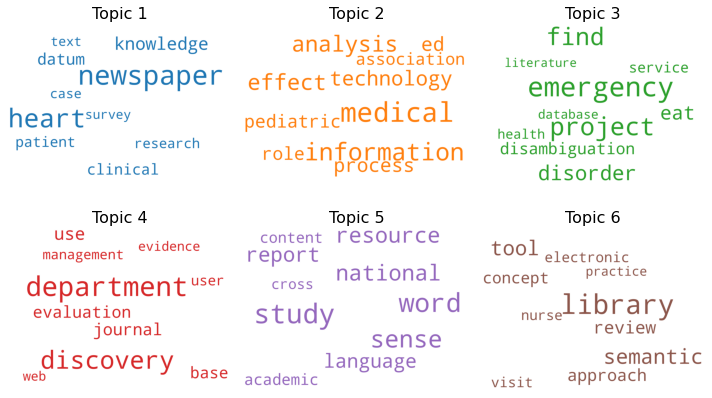

In [21]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
 

In [22]:
from gensim import corpora, models, utils
from gensim.test.utils import common_corpus, common_dictionary
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'C:\mallet-2.0.8'})
#os.environ['MALLET_HOME'] = 'D:/python\/Anaconda/Lib/site-packages/gensim/models/wrappers/mallet-2.0.8'
mallet_path = r'C:\mallet-2.0.8\bin\mallet' # update this path
ldamallet =  gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, prefix='temp_file_', workers=4)


In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('health', 0.13359528487229863),
   ('academic', 0.08055009823182711),
   ('improve', 0.0550098231827112),
   ('electronic', 0.04911591355599214),
   ('collection', 0.0412573673870334),
   ('outcome', 0.03339882121807466),
   ('change', 0.03143418467583497),
   ('language', 0.029469548133595286),
   ('interface', 0.0275049115913556),
   ('report', 0.01768172888015717)]),
 (7,
  [('care', 0.09386281588447654),
   ('user', 0.08303249097472924),
   ('approach', 0.06498194945848375),
   ('base', 0.048736462093862815),
   ('source', 0.021660649819494584),
   ('case', 0.021660649819494584),
   ('term', 0.021660649819494584),
   ('librarian', 0.016245487364620937),
   ('implementation', 0.016245487364620937),
   ('domain', 0.01444043321299639)]),
 (12,
  [('study', 0.13163064833005894),
   ('resource', 0.04518664047151277),
   ('search', 0.043222003929273084),
   ('national', 0.043222003929273084),
   ('assessment', 0.043222003929273084),
   ('practice', 0.0412573673870334),
   ('depa

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    Perplexity = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        Perplexity.append(lda_model.log_perplexity(corpus))

    return model_list, coherence_values, Perplexity

In [25]:
# Can take a long time to run.
model_list, coherence_values, Perplexity = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=20, step=1)

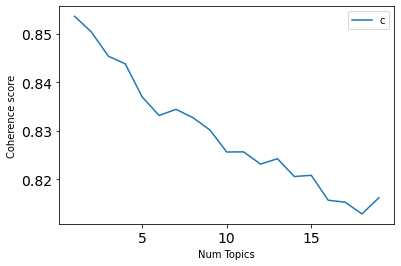

In [26]:
# Show graph
limit=20; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.tick_params(axis='both',which='major',labelsize=14)
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.savefig('coherence_values.png',transparent=True)
plt.show()

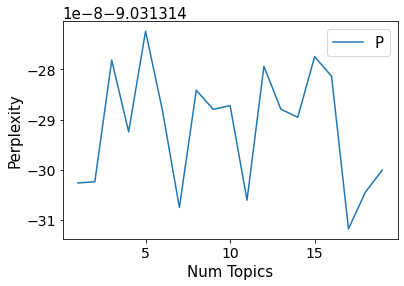

In [27]:
# Show graph
x = range(start, limit, step)
plt.plot(x, Perplexity)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("Perplexity"), loc='best')
plt.tick_params(axis='both',which='major',labelsize=14)
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.savefig('Perplexity.png',transparent=True)
plt.show()

In [30]:
print(Perplexity)

[-9.031314302643237, -9.031314302416419, -9.031314278152246, -9.031314292441808, -9.031314272389979, -9.031314288197063, -9.031314307525234, -9.031314284152135, -9.031314287970245, -9.031314287208783, -9.031314306067115, -9.031314279378146, -9.03131428792164, -9.031314289557974, -9.031314277466391, -9.031314281354707, -9.031314311813183, -9.031314304484788, -9.03131430008343]
